# Deep Neural Network on FPGA: Classifying particle jets 

Credits: [hls4ml tutorial](https://github.com/fastmachinelearning/hls4ml-tutorial)
Materials are used 

In [1]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

import numpy as np
import tensorflow as tf

%matplotlib inline
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

2025-01-28 01:54:47.061428: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-28 01:54:47.108648: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-28 01:54:47.905473: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Section 1: Dataset

### 1.1 Fetch the jet tagging dataset from Open ML

In [2]:
data = fetch_openml("hls4ml_lhc_jets_hlf", parser="auto")
X, y = data["data"], data["target"]

### 1.2 Visualize the Dataset

In [3]:
print(f"Feature names: {data['feature_names']}")
print(f"Target names: {y.dtype.categories.to_list()}")
print(f"Shapes: {X.shape}, {y.shape}")
print(f"Inputs: {X}")
print(f"Targets: {y}")

Feature names: ['zlogz', 'c1_b0_mmdt', 'c1_b1_mmdt', 'c1_b2_mmdt', 'c2_b1_mmdt', 'c2_b2_mmdt', 'd2_b1_mmdt', 'd2_b2_mmdt', 'd2_a1_b1_mmdt', 'd2_a1_b2_mmdt', 'm2_b1_mmdt', 'm2_b2_mmdt', 'n2_b1_mmdt', 'n2_b2_mmdt', 'mass_mmdt', 'multiplicity']
Target names: ['g', 'q', 't', 'w', 'z']
Shapes: (830000, 16), (830000,)
Inputs:            zlogz  c1_b0_mmdt  c1_b1_mmdt  c1_b2_mmdt  c2_b1_mmdt  c2_b2_mmdt  \
0      -2.935125    0.383155    0.005126    0.000084    0.009070    0.000179   
1      -1.927335    0.270699    0.001585    0.000011    0.003232    0.000029   
2      -3.112147    0.458171    0.097914    0.028588    0.124278    0.038487   
3      -2.666515    0.437068    0.049122    0.007978    0.047477    0.004802   
4      -2.484843    0.428981    0.041786    0.006110    0.023066    0.001123   
...          ...         ...         ...         ...         ...         ...   
829995 -3.575320    0.473246    0.040693    0.005605    0.053711    0.004402   
829996 -2.408292    0.429539    0.0400

#### Input Variables:

- Many of these variables are energy correlation functions $N$, $M$, $C$, and $D$ ([1305.0007](https://arxiv.org/pdf/1305.0007.pdf), [1609.07483](https://arxiv.org/pdf/1609.07483.pdf)). 
- The others are the jet mass (computed with modified mass drop) $m_\mathrm{mMDT}$, $\sum z\\log z$ where the sum is over the particles in the jet,
- $z$ is the fraction of jet momentum carried by a given particle,
- the overall multiplicity of particles in the jet.

#### Lets plot the input variables

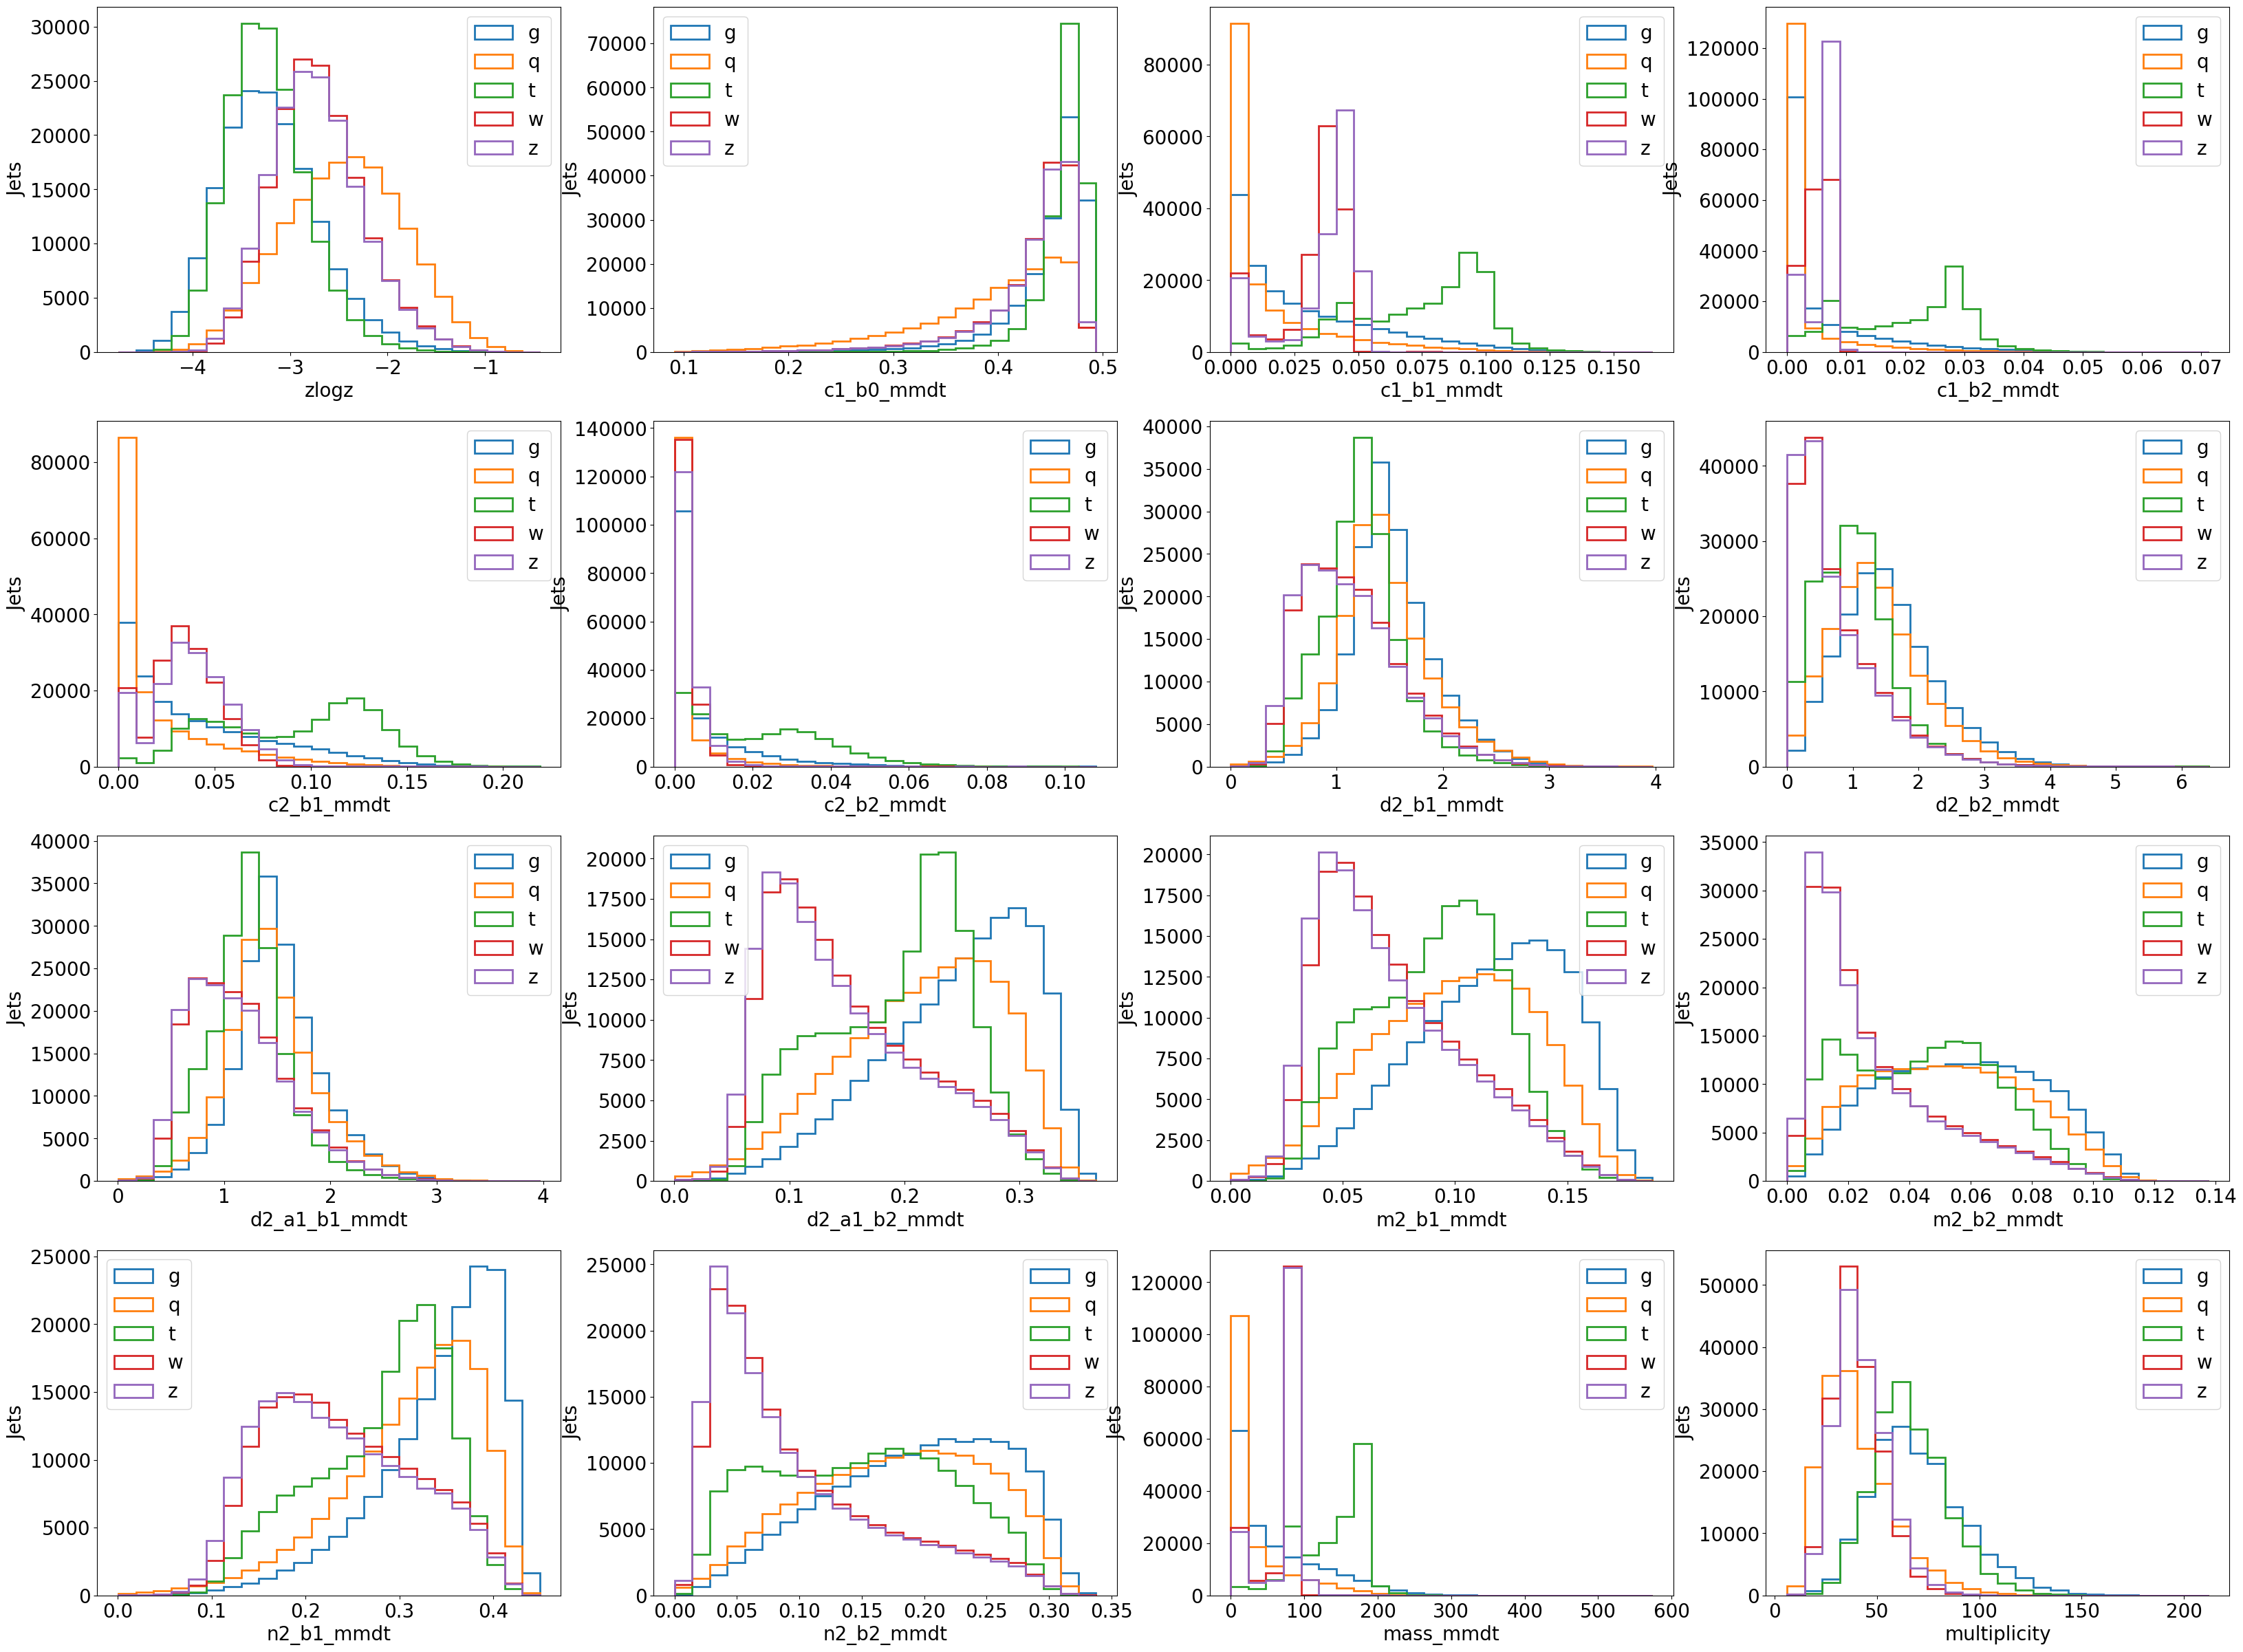

In [4]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 4, figsize=(40, 30))

for ix, ax in enumerate(axs.reshape(-1)):
    feat = data["feature_names"][ix]
    bins = np.linspace(np.min(X[:][feat]), np.max(X[:][feat]), 25)
    for c in y.dtype.categories:
        ax.hist(X[y == c][feat], bins=bins, histtype="step", label=c, lw=2)
    ax.set_xlabel(feat, fontsize=20)
    ax.set_ylabel("Jets", fontsize=20)
    ax.tick_params(axis="both", which="major", labelsize=20)
    ax.legend(fontsize=20, loc="best")
#plt.tight_layout()
plt.show()

#### Target Variables: 

As you see above, the `y` target is an array of strings, e.g. `["g", "w", ...]` etc. These correspond to different source particles for the jets. You will notice that except for quark- and gluon-initiated jets (`"g"`), all other jets in the dataset have at least one “prong.”

As the `y` target is an array of strings, e.g. `[\"g\", \"w\", ...]`, we need to make this a \"one-hot\" encoding for the training.
Then, split the dataset into training and validation sets

In [5]:
le = LabelEncoder()
y = le.fit_transform(y)
y = to_categorical(y, 5)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(y[:5])

[[1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]]


### 1.3 Let's Normalize the training and testing data

In [6]:
scaler = StandardScaler()
X_train_val = scaler.fit_transform(X_train_val)
X_test = scaler.transform(X_test)

#### We will save the training+validation and testing dataset in `npy` format

In [7]:
np.save('X_train_val.npy', X_train_val)
np.save('X_test.npy', X_test)
np.save('y_train_val.npy', y_train_val)
np.save('y_test.npy', y_test)
np.save('classes.npy', le.classes_)

## Section 2: Construct a TensorFlow DNN Model

We'll use 3 hidden layers with 64, then 32, then 32 neurons. Each layer will use relu activation. Add an output layer with 5 neurons (one for each class), then finish with Softmax activation.

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks

### 2.1 Define the architecture

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks

In [9]:
model = Sequential(name="Sequential: DNN")
model.add(Dense(64, input_shape=(16,), name='fc1', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu1'))
model.add(Dense(32, name='fc2', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu2'))
model.add(Dense(32, name='fc3', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu3'))
model.add(Dense(5, name='output', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='softmax', name='softmax'))

2025-01-28 01:54:59.639993: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 42075 MB memory:  -> device: 0, name: NVIDIA L40, pci bus id: 0000:ca:00.0, compute capability: 8.9
/opt/conda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### Print the model summary

In [10]:
model.summary()

Model: "Sequential: DNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ fc1 (Dense)                     │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1 (Activation)              │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2 (Activation)              │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc3 (Dense)                     │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu3 (Activation)              │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 5)              │           165 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Activation)            │ (None, 5)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,389 (17.14 KB)

 Trainable params: 4,389 (17.14 KB)

 Non-trainable params: 0 (0.00 B)

## 2.2 Train the model

We'll use Adam optimizer with `categorical crossentropy` loss. The callbacks will decay the learning rate and save the model into a directory 'model_1' The model isn't very complex, so this should just take a few minutes even on the CPU. If you've restarted the notebook kernel after training once, set `train = False` to load the trained model.

In [11]:
train = False
if train:
    adam = Adam(learning_rate=0.0001)
    model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    callbacks = all_callbacks(stop_patience = 1000,
                              lr_factor = 0.5,
                              lr_patience = 10,
                              lr_epsilon = 0.000001,
                              lr_cooldown = 2,
                              lr_minimum = 0.0000001,
                              outputDir = 'model_1')
    model.fit(X_train_val, y_train_val, batch_size=1024,
              epochs=30, validation_split=0.25, shuffle=True,
              callbacks = callbacks.callbacks)
else:
    from tensorflow.keras.models import load_model
    model = load_model('model_1/KERAS_check_best_model.h5')

/opt/conda/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [12]:
from plotting import makeRoc, plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix

y_keras = model.predict(X_test, batch_size=1024, verbose=0)
print(f"Accuracy: {accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))}")

I0000 00:00:1738029301.569583    3053 service.cc:145] XLA service 0x7f0fcc003110 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738029301.569625    3053 service.cc:153]   StreamExecutor device (0): NVIDIA L40, Compute Capability 8.9
2025-01-28 01:55:01.574456: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-28 01:55:01.615598: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902
I0000 00:00:1738029302.935593    3053 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Accuracy: 0.7502590361445783


<Figure size 500x500 with 0 Axes>

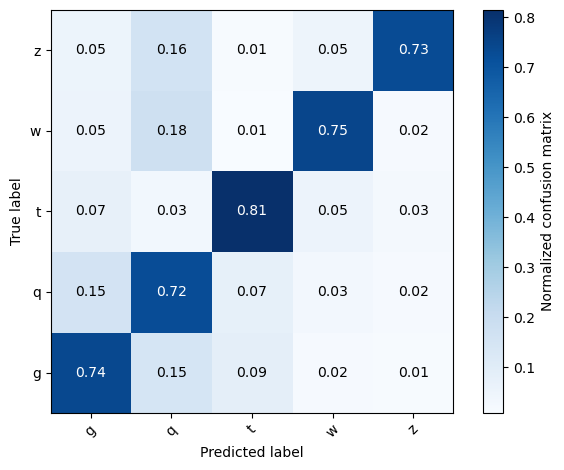

In [13]:
plt.figure(figsize=(5, 5))
plot_confusion_matrix(y_test, y_keras, classes=le.classes_, normalize=True)

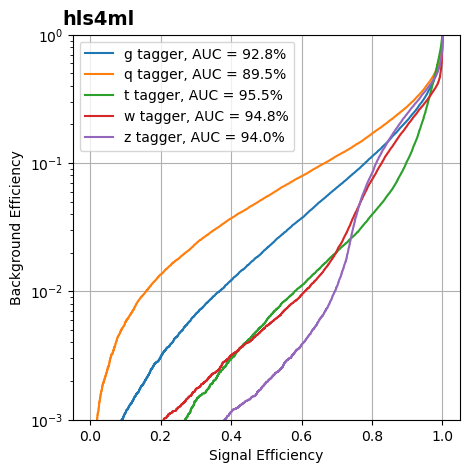

In [15]:
plt.figure(figsize=(5,5))
_ = makeRoc(y_test, y_keras, le.classes_)

## Section 3: Convert the model to FPGA firmware with `hls4ml`

Now we will go through the steps to convert the model we trained to a low-latency optimized FPGA firmware with hls4ml. First, we will evaluate its classification performance to make sure we haven't lost accuracy using the fixed-point data types. Then we will synthesize the model with Vitis HLS and check the metrics of latency and FPGA resource usage.

### 3.1 Make an hls4ml config & model
The hls4ml Neural Network inference library is controlled through a configuration dictionary. In this example we'll use the most simple variation, later exercises will look at more advanced configuration.

In [ ]:
import hls4ml

config = hls4ml.utils.config_from_keras_model(model, granularity='model', backend='Vitis')
print("-----------------------------------")
print("Configuration")
plotting.print_dict(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, backend='Vitis', output_dir='model_1/hls4ml_prj', part='xcu250-figd2104-2L-e'
)

#### Let's visualise what we created. The model architecture is shown, annotated with the shape and data types



In [ ]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)


### 3.2 Compile the HLS model and predict

In [ ]:
hls_model.compile()
X_test = np.ascontiguousarray(X_test)
y_hls = hls_model.predict(X_test)

### 3.3 Compare the Results

In [ ]:
print("Keras  Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
print("hls4ml Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_keras, le.classes_)
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test, y_hls, le.classes_, linestyle='--')

from matplotlib.lines import Line2D

lines = [Line2D([0], [0], ls='-'), Line2D([0], [0], ls='--')]
from matplotlib.legend import Legend

leg = Legend(ax, lines, labels=['keras', 'hls4ml'], loc='lower right', frameon=False)
ax.add_artist(leg)

### 3.4 Synthesize

Now we'll actually use Vitis HLS to synthesize the model. We can run the build using a method of our hls_model object. After running this step, we can integrate the generated IP into a workflow to compile for a specific FPGA board. In this case, we'll just review the reports that Vitis HLS generates, checking the latency and resource usage.

This can take several minutes.

While the C-Synthesis is running, we can monitor the progress looking at the log file by opening a terminal from the notebook home, and executing:

In [ ]:
hls_model.build(csim=False)

### 3.5 Check the reports

Print out the reports generated by Vitis HLS. Pay attention to the Latency and the 'Utilization Estimates' sections


In [ ]:
hls4ml.report.read_vivado_report('model_1/hls4ml_prj/')
